In [1]:
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import DataLoader
from IPython.display import clear_output

In [2]:
SEED = 1
BATCH_SIZE = 32
LR = 0.00030
EPOCHS = 4
CLIP = 0.1
UP_PROP = 0.25
GAMMA_EX = 0.999
GAMMA_IN = 0.99
LAMBDA = 0.95
ENT_COEF = 0.001
EX_COEF = 2.0
IN_COEF = 1.0
V_CLIP = True
EPS = np.finfo(np.float).eps

# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

cuda: True


In [3]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )
        self.pol = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, action_space)
        )
        self.val_ex = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, 1)
        )
        self.val_in = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, 1)
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        out = self.head(x)
        logit = self.pol(out).reshape(out.shape[0], -1)
        value_ex = self.val_ex(out).reshape(out.shape[0], 1)
        value_in = self.val_in(out).reshape(out.shape[0], 1)
        log_probs = self.log_softmax(logit)
        
        return log_probs, value_ex, value_in
    

class RandomNet(nn.Module):
    def __init__(self, obs_space):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )
        self.fc = nn.Sequential(
            nn.Linear(obs_space*10, 512)
        )

    def forward(self, x):
        out = self.head(x)
        obs_feature = self.fc(out).reshape(out.shape[0], -1)

        return obs_feature


class PredictNet(nn.Module):
    def __init__(self, obs_space):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )
        self.fc = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, 512)
        )

    def forward(self, x):
        out = self.head(x)
        obs_feature = self.fc(out).reshape(out.shape[0], -1)

        return obs_feature

In [4]:
losses = []
m_losses = []
f_losses = []


def learn(net, old_net, pred_net, rand_net, optimizer, train_memory):
    global CLIP
    net.train()
    old_net.train()

    for i in range(EPOCHS):
        dataloader = DataLoader(
            train_memory,
            shuffle=True,
            batch_size=BATCH_SIZE,
            pin_memory=use_cuda
        )
        for (s, a, _s, ret_ex, ret_in, adv_ex, adv_in) in dataloader:
            s = s.to(device).float()
#             s_norm_np = normalize_obs(s.detach().cpu().numpy())
#             s_norm = torch.tensor(s_norm_np, requires_grad=True).to(device).float()
            a  = a.to(device).long()
            _s = _s.to(device).float()
            _s_norm_np = normalize_obs(_s.detach().cpu().numpy())
            _s_norm = torch.tensor(_s_norm_np, requires_grad=True).to(device).float()
            ret_ex = ret_ex.to(device).float()
            ret_in = ret_in.to(device).float()
            adv = (adv_ex + adv_in).to(device).float()

            with torch.no_grad():
                rand_f = rand_net(_s_norm)
                log_p_old, v_ex_old, v_in_old = old_net(s)
                log_p_a_old = log_p_old[range(BATCH_SIZE), a]

            pred_f = pred_net(_s_norm)
            log_p, v_ex, v_in = net(s)
            log_p_a = log_p[range(BATCH_SIZE), a]
            p_ratio = (log_p_a - log_p_a_old).exp()
            p_r_clip = torch.clamp(p_ratio, 1. - CLIP, 1. + CLIP)
            p_loss = torch.min(p_ratio * adv, p_r_clip * adv).mean()
            
            if V_CLIP:
                v_ex_clip = v_ex_old + \
                    torch.clamp(v_ex - v_ex_old, -CLIP, CLIP)
                v_ex_loss1 = (ret_ex - v_ex_clip).pow(2)
                v_ex_loss2 = (ret_ex - v_ex).pow(2)
                v_ex_loss = 0.5 * torch.max(v_ex_loss1, v_ex_loss2)
                v_in_clip = v_in_old + \
                    torch.clamp(v_in - v_in_old, -CLIP, CLIP)
                v_in_loss1 = (ret_in - v_in_clip).pow(2)
                v_in_loss2 = (ret_in - v_in).pow(2)
                v_in_loss = 0.5 * torch.max(v_in_loss1, v_in_loss2)
            else:
                v_ex_loss = 0.5 * (ret_ex - v_ex).pow(2)
                v_in_loss = 0.5 * (ret_in - v_in).pow(2)
            
            v_loss = (v_ex_loss + v_in_loss).mean() 
            m = Categorical(log_p.exp())
            entropy = m.entropy().mean()

            # loss
            m_loss = -(p_loss - v_loss + ENT_COEF * entropy)
            m_losses.append(m_loss)

            f_loss = (pred_f - rand_f).pow(2)
            mask = torch.rand(f_loss.shape[1]).to(device)
            mask = (mask < UP_PROP).to(device).float()
            f_loss = (f_loss * mask).sum() / mask.sum().clamp(min=1)
            f_losses.append(f_loss)
            
            loss = m_loss + f_loss
            losses.append(loss)
            
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(total_params, max_norm=0.5)
            optimizer.step()

#         CLIP = max(CLIP * 0.999, 0.0001)
    train_memory.clear()


def get_action_and_value(obs, old_net):
    old_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p, v_ex, v_in = old_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()

    return action.item(), v_ex.item(), v_in.item()


def compute_adv_with_gae(rews_ex, rews_in, vals_ex, vals_in, roll_memory):
    rew_ex = np.array(rews_ex, 'float')
    rew_in = np.array(rews_in, 'float')
    val_ex = np.array(vals_ex[:-1], 'float')
    val_in = np.array(vals_in[:-1], 'float')
    _val_ex = np.array(vals_ex[1:], 'float')
    _val_in = np.array(vals_in[1:], 'float')
    dt_ex = rew_ex + GAMMA_EX * _val_ex - val_ex
    dt_in = rew_in + GAMMA_IN * _val_in - val_in
    dis_r_ex = np.array([GAMMA_EX**(i) * r for i, r in enumerate(rews_ex)], 'float')
    dis_r_in = np.array([GAMMA_IN**(i) * r for i, r in enumerate(rews_in)], 'float')
    gae_ex = np.array([(GAMMA_EX * LAMBDA)**(i) * dt for i, dt in enumerate(dt_ex.tolist())], 'float')
    gae_in = np.array([(GAMMA_IN * LAMBDA)**(i) * dt for i, dt in enumerate(dt_in.tolist())], 'float')
    for i, data in enumerate(roll_memory):
        data.append(sum(dis_r_ex[i:] / GAMMA_EX**(i)))
        data.append(sum(dis_r_in[i:] / GAMMA_IN**(i)))
        data.append(sum(gae_ex[i:] / (GAMMA_EX * LAMBDA)**(i)))
        data.append(sum(gae_in[i:] / (GAMMA_IN * LAMBDA)**(i)))
    rews_ex.clear()
    rews_in.clear()
    vals_ex.clear()
    vals_in.clear()

    return roll_memory


def get_norm_params(obs_memory):
    global obs_apace

    obses = [[] for _ in range(obs_space)]
    for obs in obs_memory:
        for j in range(obs_space):
            obses[j].append(obs[j])

    mean = np.zeros(obs_space, 'float')
    std = np.zeros(obs_space, 'float')
    for i, obs_ in enumerate(obses):
        mean[i] = np.mean(obs_)
        std[i] = np.std(obs_)
    obs_memory.clear()

    return mean, np.clip(std, a_min=EPS, a_max=None)


def normalize_obs(obs):
    global mean, std
    norm_obs = (obs - mean) / std

    return np.clip(norm_obs, -5, 5)


def calculate_reward_in(pred_net, rand_net, obs):
    norm_obs = normalize_obs(obs)
    state = torch.tensor([norm_obs]).to(device).float()
    with torch.no_grad():
        pred_obs = pred_net(state)
        rand_obs = rand_net(state)
        reward = (pred_obs - rand_obs).pow(2).sum()
        clipped_reward = torch.clamp(reward, -1, 1)

    return clipped_reward.item()


def simulation(env):
    global mean, std
    init_steps = 0
    obs_mem = []
    while True:
        obs = env.reset()
        done = False
        while not done:
    #         env.render()
            action = env.action_space.sample()
            _obs, _, done, _ = env.step(action)
            obs_mem.append(_obs)
            init_steps += 1
            if init_steps == 256*1000:
                mean, std = get_norm_params(obs_mem)
                done = True
        if done:
            if init_steps == 256*1000:
                env.close()
                break
                
                
def plot():
    clear_output(True)
    plt.figure(figsize=(16, 8))
    plt.subplot(221)
    plt.plot(ep_rewards)
    plt.title('Extrinsic Reward')
    plt.subplot(223)
    plt.plot(in_rewards)
    plt.title('Intrinsic Reward')
    plt.subplot(222)
    plt.plot(m_losses)
    plt.title('Main Loss')
    plt.subplot(224)
    plt.plot(f_losses)
    plt.title('Predictor Loss')
    plt.show()

## Main

In [ ]:
# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 3000
roll_len = 256
n_eval = env.spec.trials

# global values
steps = 0
mean = 0.
std = 0.
ep_rewards = []
in_rewards = []
is_rollout = False
is_solved = False

# make a rollout memory
net_memory = deque(maxlen=2)
train_memory = []
roll_memory = []
obs_memory = []
rews_ex = []
rews_in = []
vals_ex = []
vals_in = []

# make nerual networks
net = ActorCriticNet(obs_space, action_space).to(device)
old_net = deepcopy(net)
net_memory.appendleft(net.state_dict())
pred_net = PredictNet(obs_space).to(device)
rand_net = RandomNet(obs_space).to(device)

# make optimizer
total_params = list(net.parameters()) + list(pred_net.parameters())
optimizer = torch.optim.Adam(total_params, lr=LR, eps=1e-5)

/home/jay/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [ ]:
env.spec.max_episode_steps

1000

In [ ]:
env.spec.trials

100

In [ ]:
env.spec.reward_threshold

200

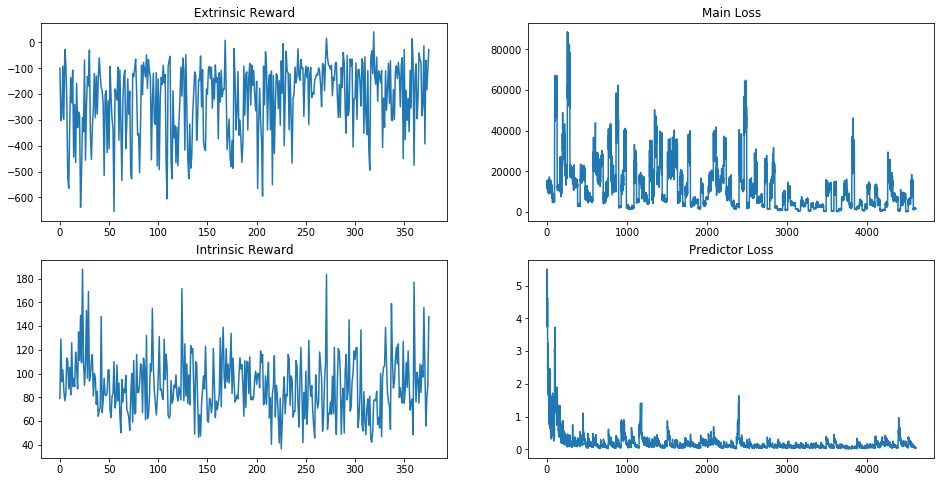

In [ ]:
# play!
simulation(env)
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_rew_ex = 0.
    ep_rew_in = 0.
    while not done:
#         env.render()

        action, val_ex, val_in = get_action_and_value(obs, old_net)
        _obs, rew_ex, done, _ = env.step(action)
        
        rew_in = calculate_reward_in(pred_net, rand_net, _obs)    
        
        # store
        roll_memory.append([obs, action, _obs])
        obs_memory.append(_obs)
        rews_ex.append(0.5 * EX_COEF * rew_ex)
        rews_in.append(0.5 * IN_COEF * rew_in)
        vals_ex.append(0.5 * val_ex)
        vals_in.append(0.5 * val_in)
        
        obs = _obs
        steps += 1
        ep_rew_ex += rew_ex
        ep_rew_in += rew_in
        
        if done or steps % roll_len == 0:
            if done:
                _val_ex = 0.
                _val_in = 0.
            else:
                _, _val_ex, _val_in = get_action_and_value(_obs, old_net)
            
            vals_ex.append(_val_ex)
            vals_in.append(_val_in)
            train_memory.extend(
                compute_adv_with_gae(rews_ex, rews_in, vals_ex, vals_in, roll_memory)
            )
            roll_memory.clear()
            
        if steps % roll_len == 0:
            learn(net, old_net, pred_net, rand_net, optimizer, train_memory)
            old_net.load_state_dict(net.state_dict())
            mean, std = get_norm_params(obs_memory)
    
    if done:        
        ep_rewards.append(ep_rew_ex)
        in_rewards.append(ep_rew_in)
        plot()
#         print('{:3} Episode in {:5} steps, '
#               'reward_ex {:.2f}, reward_in {:.2f}'.format(i, steps, ep_rew_ex, ep_rew_in))
        
        if env.spec.id == 'MountainCar-v0' and ep_rew_ex > -200:
            print('################################################################################ Wow!')
        
        if len(ep_rewards) >= n_eval:
            if np.mean(list(reversed(ep_rewards))[: n_eval]) >= env.spec.reward_threshold:
                print('\n{} is sloved! '
                      '{:3} Episode in {:3} steps'.format(env.spec.id, i, steps))
                torch.save(net.state_dict(),
                           f'../test/saved_models/{env.spec.id}_ep{i}_clear_model_ppo_r.pt')
                break
env.close()

In [ ]:
[
    ('CartPole-v0', 161, 32, 256),
    ('CartPole-v1', 161, 32, 256),
    ('MountainCar-v0', None),
    ('LunarLander-v2', None)
]